# Analysis of NYC Bike Share Citi Bike Data
__<font size="4">by Minjian Wu</font>__

NYC Bike Share operates Citi Bike program and generates data regarding the program, including trip records, a real time feed of station status and monthly reports. The Citi Bike program data is exclusively generated by the operator NYC Bike Share, a limited liability corporation solely owned by Motivate.

The data includes (for each month of a year):
- Trip Duration in seconds
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (0 = unknown; 1 = male; 2 = female)
- Year of Birth

This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of the “test” stations, and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it's secure).

## Preliminary Wrangling

Looking at the data, we are motivated by a few questions, for example: Where do Citi Bikers ride? How far do they go? When are most trips taken in terms of time of day, day of the week, or month of the year? Which stations are most popular? How long does the average trip take? Does any of these depend on if a user is a subscriber or customer, a male or female, and/or some certain age? 

We are going to find these out from exploration of the downloaded dataset. We will leverage Python's visualisation libraries to help with our analyses.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import folium

%matplotlib inline

Load in our dataset and describe its properties through the screening questions at the end of the section.
We will try and motivate our exploration goals through this section.

In [3]:
from bs4 import BeautifulSoup as bs
import os
import requests
from zipfile import ZipFile
from io import BytesIO

# # parse the domain html
# domain='https://s3.amazonaws.com/tripdata'
# soup = bs(requests.get(domain).content, 'html.parser')

# folder_name = 'NYC_bike_data'
# # Make directory if it doesn't already exist
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)

# # download files and unzip to folder
# for link in soup.find_all('key'):
#     if link.text.startswith('2020'):  # only need 2020 data
#         r = requests.get(domain + '/' + link.text)
#         f = ZipFile(BytesIO(r.content))
#         f.extractall(os.path.join(folder_name))

In [3]:
# # concatenate the 12 dataframes (1 from each month of 2020)
# df_2020_months = {
#     'df_{:02d}'.format(i):
#     pd.read_csv('NYC_bike_data/2020' + '{:02d}'.format(i) +
#                 '-citibike-tripdata.csv')
#     for i in range(1, 13)
# }

# df_2020 = pd.concat(df_2020_months.values(), ignore_index=True)

In [4]:
# # write the concatenated dataframe to a csv for re-use
# df_2020.to_csv('NYC_bike_2020.csv')

### Data inspection

In [5]:
df_2020 = pd.read_csv('NYC_bike_2020.csv', index_col=False)
df_2020.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df_2020.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,789,2020-01-01 00:00:55.3900,2020-01-01 00:14:05.1470,504,1 Ave & E 16 St,40.732219,-73.981656,307,Canal St & Rutgers St,40.714275,-73.9899,30326,Subscriber,1992,1


In [7]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19506857 entries, 0 to 19506856
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         int64  
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           int64  
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               int64  
 14  gender                   int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 2.2+ GB


In [8]:
# total number of duplicated rows
df_2020.duplicated().sum()

0

In [9]:
# total number of NaN/null values
df_2020.isna().sum().sum()

0

In [10]:
df_2020['gender'].value_counts()  # 0 for unknown gender - no use

1    11798407
2     5551873
0     2156577
Name: gender, dtype: int64

In [11]:
df_2020['usertype'].value_counts()

Subscriber    14955766
Customer       4551091
Name: usertype, dtype: int64

### Data Cleaning

In [12]:
# make a copy of the original dataframe
df_2020_cl = df_2020.copy()

In [13]:
# remove unknown genders
df_2020_cl = df_2020_cl[df_2020_cl['gender'] != 0]
df_2020_cl.reset_index(inplace=True, drop=True)
df_2020_cl['gender'].value_counts()

1    11798407
2     5551873
Name: gender, dtype: int64

In [14]:
# convert time columns to datatime objects
df_2020_cl['starttime'] = pd.to_datetime(df_2020_cl['starttime'])
df_2020_cl['stoptime'] = pd.to_datetime(df_2020_cl['stoptime'])

In [15]:
# convert birthyear to age at time of 2020
df_2020_cl['age'] = 2020 - df_2020_cl['birth year']
df_2020_cl.drop('birth year', axis=1, inplace=True)

In [19]:
# Calculate the straight line distance from the start and end Lat/Long
def line_dist(row):
    # convert decimal degrees to radians
    lat1, long1, lat2, long2 = row[[
        'start station latitude', 'start station longitude',
        'end station latitude', 'end station longitude'
    ]]
    lat1, long1, lat2, long2 = map(np.radians, [lat1, long1, lat2, long2])
    # haversine formula
    d_long = long2 - long1
    d_lat = lat2 - lat1
    a = np.sin(
        d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_long / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    dist = 6371 * c  # earth radius is approx. 6371km
    return dist

# make a new column with unit in km
df_2020_cl['dist stations'] = df_2020_cl.apply(line_dist, axis=1)

In [20]:
# check out the cleaned dataframe
df_2020_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17350280 entries, 0 to 17350279
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start station id         int64         
 4   start station name       object        
 5   start station latitude   float64       
 6   start station longitude  float64       
 7   end station id           int64         
 8   end station name         object        
 9   end station latitude     float64       
 10  end station longitude    float64       
 11  bikeid                   int64         
 12  usertype                 object        
 13  gender                   int64         
 14  age                      int64         
 15  dist stations            float64       
dtypes: datetime64[ns](2), float64(5), int64(6), object(3)
memory usage: 2.

In [21]:
df_2020_cl

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,gender,age,dist stations
0,789,2020-01-01 00:00:55.390,2020-01-01 00:14:05.147,504,1 Ave & E 16 St,40.732219,-73.981656,307,Canal St & Rutgers St,40.714275,-73.989900,30326,Subscriber,1,28,2.112754
1,1541,2020-01-01 00:01:08.102,2020-01-01 00:26:49.178,3423,West Drive & Prospect Park West,40.661063,-73.979453,3300,Prospect Park West & 8 St,40.665147,-73.976376,17105,Customer,1,51,0.522978
2,1464,2020-01-01 00:01:42.140,2020-01-01 00:26:07.011,3687,E 33 St & 1 Ave,40.743227,-73.974498,259,South St & Whitehall St,40.701221,-74.012342,40177,Subscriber,1,57,5.655762
3,592,2020-01-01 00:01:45.561,2020-01-01 00:11:38.155,346,Bank St & Hudson St,40.736529,-74.006180,490,8 Ave & W 33 St,40.751551,-73.993934,27690,Subscriber,1,40,1.963301
4,702,2020-01-01 00:01:45.788,2020-01-01 00:13:28.240,372,Franklin Ave & Myrtle Ave,40.694546,-73.958014,3637,Fulton St & Waverly Ave,40.683239,-73.965996,32583,Subscriber,1,38,1.426126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17350275,1178,2020-12-31 23:58:14.100,2021-01-01 00:17:52.338,3335,Union St & 4 Ave,40.677274,-73.982820,3860,Wilson Ave & Troutman St,40.701660,-73.927540,47991,Customer,1,32,5.392248
17350276,1344,2020-12-31 23:58:17.480,2021-01-01 00:20:41.607,456,E 53 St & Madison Ave,40.759711,-73.974023,468,Broadway & W 56 St,40.765265,-73.981923,36946,Subscriber,1,26,0.907857
17350277,589,2020-12-31 23:58:21.262,2021-01-01 00:08:10.922,3999,Adam Clayton Powell Blvd & W 138 St,40.816960,-73.942296,3518,Lenox Ave & W 126 St,40.808442,-73.945209,48973,Subscriber,1,23,0.978335
17350278,2045,2020-12-31 23:58:21.704,2021-01-01 00:32:27.157,526,E 33 St & 5 Ave,40.747659,-73.984907,3614,Crescent St & 30 Ave,40.768692,-73.924957,36467,Subscriber,1,26,5.564695


In [22]:
# write the cleaned dataframe to a csv for re-use
df_2020_cl.to_csv('NYC_bike_2020_cleaned.csv')

### Discussions
##### What is the structure of our dataset?

12 months of bike share data in NYC are concatenated one after the other and then cleaned (preliminarily) to form a large 17350280 × 16 shaped dataframe.

##### What is/are the main feature(s) of interest in our dataset? What features in the dataset do you think will help support your investigation into your feature(s) of interest?

- Where do Citi Bikers ride (in terms of destination as route taken is unknown)? 
  <br>$end\ station\ id$
  <br>$start\ \&\ end\ station\ Lat/Long$ $(possibly\ shown\ on\ a\ map)$
- How far do they go (in terms of straight line distance as route taken is unknown)? 
  <br>$dist\ stations$
- When are most trips taken in terms of time of day, day of the week, or month of the year? 
  <br>$starttime,\ stoptime$
- Which stations are most popular? 
  <br>$start\ \&\ end\ station\ id$
- How long does the average trip take? 
  <br>$tripduration$
- Does any of the above depend on if a user is a subscriber or customer, a male or female, and/or some certain age? 
  <br>$user\ type,\ gender,\ age$


## Univariate Exploration

In this section, we will investigate distributions of individual variables. If
we see unusual points or outliers, we will take a deeper look to clean things up
and be prepared to look at relationships between variables.

In [4]:
# read in the cleaned dataframe from file
data = pd.read_csv('NYC_bike_2020_cleaned.csv', index_col=False)
data.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# convert time columns to datatime objects
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

In [6]:
# In fact, for plotting, it's easier if we 
# transform gender labels to [male, female] instead of [1,2]
data['gender'] = data['gender'].map({1: 'male', 2: 'female'})

In [7]:
# stats for numerical variables
data[['tripduration', 'age', 'dist stations']].describe()

,tripduration,age,dist stations
count,1.735028e+07,1.735028e+07,1.735028e+07
mean,1.174433e+03,3.749510e+01,2.026323e+00
std,1.159484e+04,1.231108e+01,1.722556e+00
min,6.100000e+01,1.600000e+01,0.000000e+00
25%,4.060000e+02,2.800000e+01,8.302960e-01
50%,7.420000e+02,3.400000e+01,1.529866e+00
75%,1.341000e+03,4.500000e+01,2.734512e+00
max,3.786187e+06,1.470000e+02,2.140269e+01


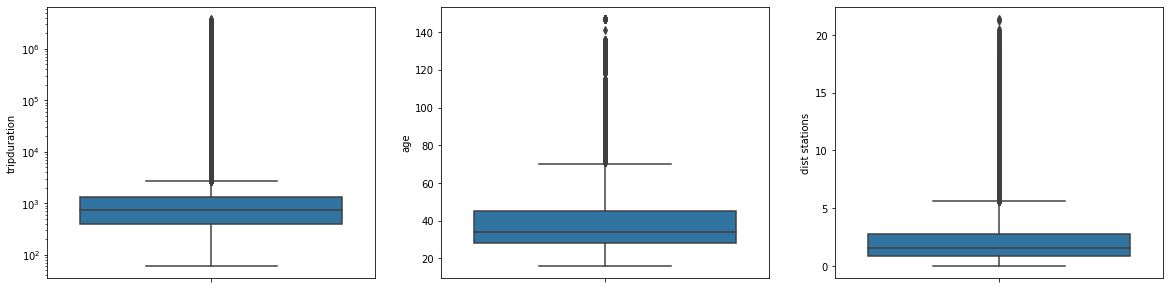

In [8]:
# subplots of box plots for the three numerical variables
plt.figure(figsize=[20, 5])
to_plot = data

# left plot: trip duration
plt.subplot(1, 3, 1)
sns.boxplot(data=to_plot, y='tripduration')
plt.yscale('log');  # some are too large to be on a normal scale

# center plot: age
plt.subplot(1, 3, 2)
sns.boxplot(data=to_plot, y='age');

# rght plot: dist stations
plt.subplot(1, 3, 3)
sns.boxplot(data=to_plot, y='dist stations');

It is obvious that there are quite a number of incredible outliers, for example, day-long trip durations, above-100 aged bike riders. But it is not too unusual to have tens of km apart between the bike stations. 

We can also see that there are zero distance data points, indicating the same start and end station locations (Lat/Long coordinates) - these might be erroneous or simply that the biker started from a place and then returned to the same. We will remove these.

Given the large dataset, it may be reasonable to remove all outliers (i.e. beyond 1.5 x IQR down from Q1 or up from Q3). We'd be expecting the majority of the representative data to remain in the dataframe.

In [9]:
# find the quantile min and max and return a mask for values in between
def filt_min_max(col):
    min_v = col.quantile(.25) - stats.iqr(col) * 1.5
    max_v = col.quantile(.75) + stats.iqr(col) * 1.5
    mask = col.between(min_v, max_v)
    return mask

# apply the filter to the three columns
df = data[filt_min_max(data['tripduration']) & filt_min_max(data['age'])
          & filt_min_max(data['dist stations'])]

In [10]:
# remove rows with same starting and ending station
df = df[df['dist stations'] != 0]

In [11]:
df.shape

(15263132, 16)

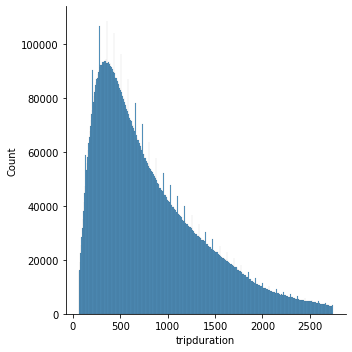

In [12]:
# trip length distribution
sns.displot(df['tripduration']);

Trip duration is right skewed with mode at around 500 seconds(~10 min). Obviously there were trips longer than an hour but those were in the right tail (as outliers) which had been cut out of the visualisation dataframe.

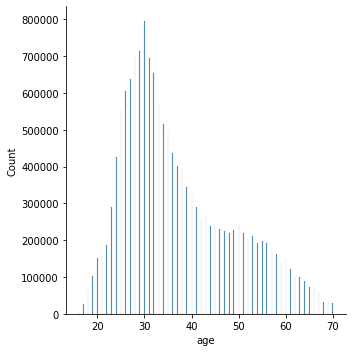

In [13]:
# age distribution
sns.displot(data=df, x='age');

Age is slightly bimodal but generally right skewed with modes at around the 30s and the 50s. There were riders older than 70 years but there weren't a lot of them and so these had been cut out of the visualisation dataframe.

It makes sense for these two age groups to lead the bike hire counts as one might use a bike for work/exercise/grocery shopping etc.

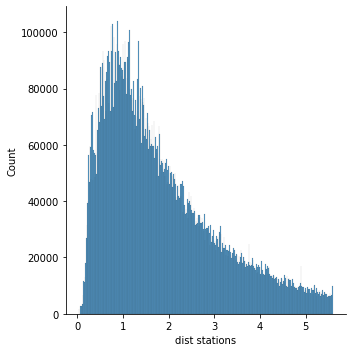

In [14]:
# station distances distribution
sns.displot(data=df, x='dist stations');

The straight line distances between start and end stations are right skewed with mode at around 1.2km. Obviously there were stations further apart than just a few kilometers but those were in the right tail (as outliers) which had been cut out of the visualisation dataframe.

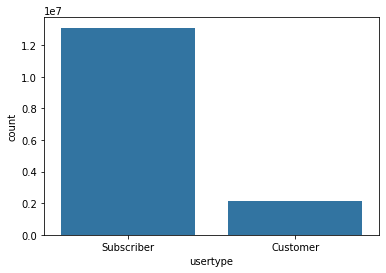

In [15]:
# countplot for the two usertypes
basic_color = sns.color_palette()[0]
sns.countplot(data=df, x='usertype', color=basic_color);

So there are much more subscribers (Annual Member) than customers (24-hour pass or 3-day pass user). This means there should be less randomness in bike rides patterns.

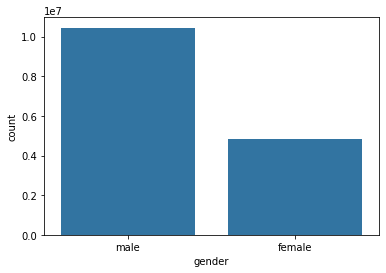

In [16]:
# countplot for genders
sns.countplot(data=df, x='gender', color=basic_color);

So about twice as many males than females that use shared bikes, although this bias maybe due to gender proportions in the population of NYC.

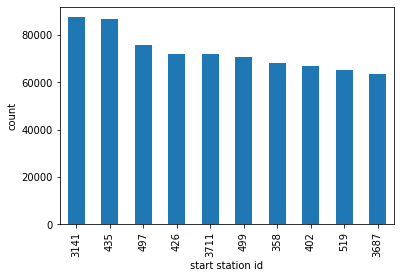

In [17]:
# most popular stations a bike ride starts from
top_10_stations = df['start station id'].value_counts()[:10]
top_10_stations.plot.bar(legend=None)
plt.xlabel('start station id')
plt.ylabel('count');

Presumably these stations are quite central so to be busy? Let's pin them on a map.

In [18]:
# get the coordinates for the top 10 stations
co_ords = df[[
    'start station id', 'start station latitude', 'start station longitude'
]]
co_ords = co_ords[co_ords['start station id'].isin(top_10_stations.index)]
co_ords = co_ords.drop_duplicates(subset='start station id')
# use a subset as there are accuracy issues with the coordinates and
# as a result, we get multiple locations (within error margin) for the same station id
# so we need to keep the first id that matches and remove the rest
co_ords

,start station id,start station latitude,start station longitude
33,3687,40.743227,-73.974498
128,519,40.751873,-73.977706
219,3141,40.765005,-73.958185
276,426,40.717548,-74.013221
296,499,40.769155,-73.981918
362,402,40.740343,-73.989551
364,3711,40.729667,-73.980680
767,435,40.741740,-73.994156
925,358,40.732916,-74.007114
1142,497,40.737050,-73.990093


In [19]:
# plot the start stations on a map to visualise location
map = folium.Map(location=[40.743227, -73.974498],
#                  tiles='Stamen Terrain',
                 zoom_start=13)  # zoom into NYC

# pin the top 10 popular stations on map
for i in range(0, 10):
    folium.Marker([co_ords.iloc[i, 1], co_ords.iloc[i, 2]],  # Lat/Long
                  popup='start station id: ' + str(co_ords.iloc[i, 0]),  # label with station id
                  opacity=0.7).add_to(map)
map

The blue pins on the map show that the majority of the top popular locations are near parks and all are central New York.

Do the same for end stations - let's see where most trips end up at.

In [20]:
# top 10 destination/end of trip stations
top_10_end_stations = df['end station id'].value_counts()[:10]

# get the coordinates
co_ords_end = df[[
    'end station id', 'end station latitude', 'end station longitude'
]]
co_ords_end = co_ords_end[co_ords_end['end station id'].isin(
    top_10_end_stations.index)]
co_ords_end = co_ords_end.drop_duplicates(subset='end station id')

# make the plot on map
map_end_stations = folium.Map(location=[40.743227, -73.974498],
                              zoom_start=13)  # zoom into NYC

# pin the top 10 popular stations on map
for i in range(0, 10):
    folium.Marker([co_ords_end.iloc[i, 1], co_ords_end.iloc[i, 2]],  # Lat/Long
                  popup='end station id: ' + \
                  str(co_ords_end.iloc[i, 0]),  # label with station id
                  opacity=0.7).add_to(map_end_stations)
map_end_stations

Exactly the same locations except for slightly different ranking for the top 10 destination bike stations! Since we have got rid of those trips that start and end at the same location (i.e. those with a straight line distance of zero), the coincidence that most trips still start and end between the same 10 stations indicates a true popularity for bikes at these locations - near parks and/or central. So if a company was to invest in putting more bikes or in setting up a snacks/drinks bar/mobile shop then these locations are ideal.

Next, let's see if there's a pattern in when people ride bikes - which months in a year, which days in a month and which hours in a day are most active?

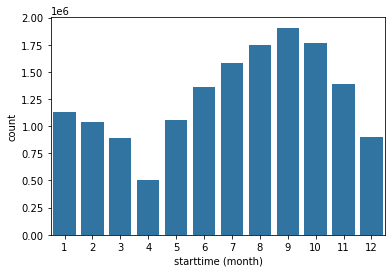

In [21]:
# most common times that a bike ride takes place - which month in year 2020?
df['start_month'] = df['starttime'].dt.month

# make a countplot:
sns.countplot(data=df, x='start_month', color=basic_color)
plt.xlabel('starttime (month)');

The ride time peaks during the summer months as expected, with September being the busiest month. 

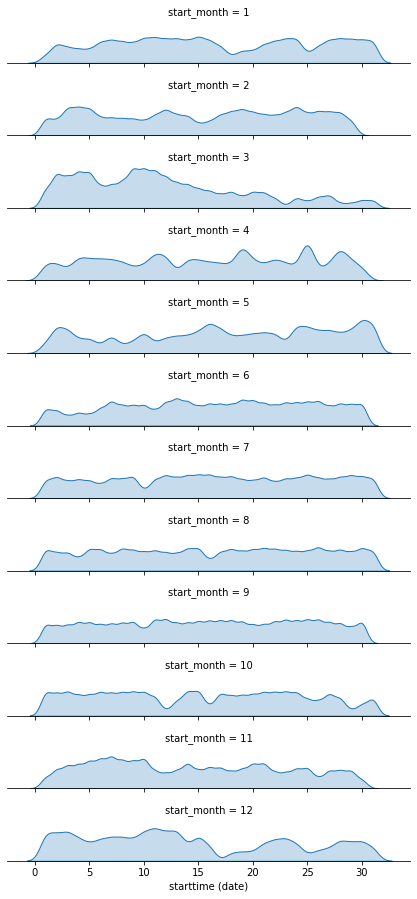

In [22]:
# most common times that a bike ride takes place - which date in a month?
df['start_date'] = pd.to_numeric(df['starttime'].dt.strftime('%d'))

# make a ridgeline plot:
g = sns.FacetGrid(data=df, row='start_month', height=1.05, aspect=6)
g.map(sns.kdeplot, 'start_date', shade=True);

# remove the y-axes
g.set(yticks=[])
g.despine(left=True)
plt.xlabel('starttime (date)');

There doesn't appear to be a particular pattern around the activities each day in a month. Otherwise, one observation we can make is that the number of daily bike rides almost flats out at high levels throughout August and September.

We can also make a plot of daily bike ride counts across all months in 2020.

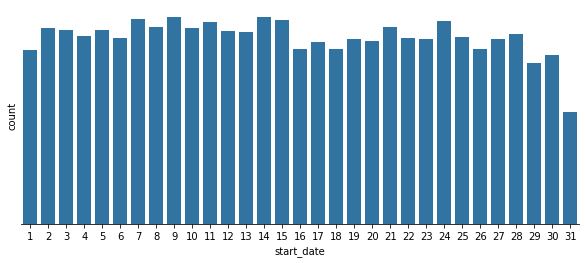

In [23]:
plt.figure(figsize=(10,4))
# group by date in a month and aggregage (count) across 12 months
sns.countplot(x=df['start_date'], color=basic_color)
plt.yticks([])
sns.despine(left=True);

One could say that throughout 2020, the first half of each month has more bike riding activities than the second half, but the difference would only be marginal. An apparent shortfall on the 31st in a month is most likely attributed to not every month has a 31st. 

In general, there is no clear pattern of one day being busier / quieter than the rest.

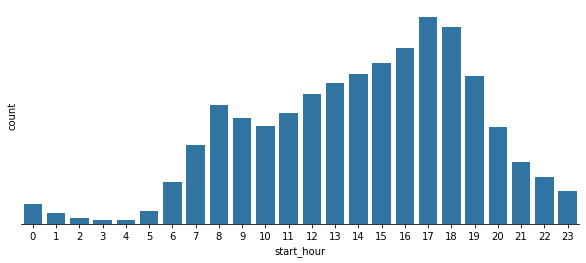

In [24]:
# most common times that a bike ride takes place - which time(s) in a day?
df['start_hour'] = df['starttime'].dt.hour

# make a countplot for the hours across all days in 2020
plt.figure(figsize=(10,4))
sns.countplot(x=df['start_hour'], color=basic_color)
plt.yticks([])
sns.despine(left=True);

The countplot is bimodal with peaks at 8am and around 5pm. And it is also evident that more people ride bikes in the afternoon, as bike activities drop slightly in the morning passing the peak time at 8 and pick up the pace gradually from lunchtime all the way towards late afternoon. Obviously not many people are riding bikes in the evening and over night. This pattern seems to follow a typical work/social/home schedule but we will dive a little deeper into whether this is also affected by the season - maybe in the summer seasons people are less tentative to ride in the afternoon when the sun is rising high?

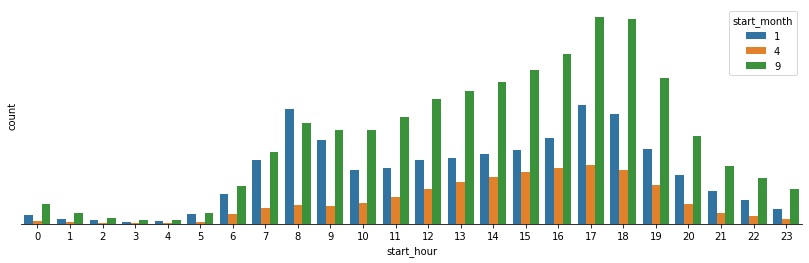

In [25]:
# any difference in this pattern in the winter and summer months?
# take January, April and September as an example
plt.figure(figsize=(14, 4))
sns.countplot(data=df[df['start_month'].isin([1, 4, 9])],
              x='start_hour',
              hue='start_month')
plt.yticks([])
sns.despine(left=True);

It appears that most bike journeys are still taken at around 8am and 5pm with the afternoon being the busiest period in a day, no matter in the warm/hot or cold months. It then follows that the peaks are likely related to people using bikes to commute between work and home - go green!

## Bivariate Exploration

In this section, we will investigate relationships between pairs of variables in our
data. The variables that we cover here should have been introduced in some
fashion in the previous section (univariate exploration).

In [26]:
# inspect the dataframe again
df.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,gender,age,dist stations,start_month,start_date,start_hour
0,789,2020-01-01 00:00:55.390,2020-01-01 00:14:05.147,504,1 Ave & E 16 St,40.732219,-73.981656,307,Canal St & Rutgers St,40.714275,-73.9899,30326,Subscriber,male,28,2.112754,1,1,0


Are longer trips (in time) correlated with distances (straight line apart) between start and end stations? If the stations are far apart, the trip will take longer. If the rider takes a longer route or perhaps makes a few stops on the way, the trip will also take longer.

Let's make a scatter plot of station distances against trip duration.

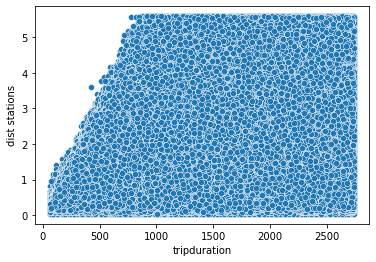

In [27]:
sns.scatterplot(data=df, x='tripduration', y='dist stations');

It makes sense that there is a gap at the top left corner - longer distance journeys cannot be completed within a short timeframe. On the other hand, short distance trips can take much longer than needed due to riders making stops or taking a detour between the start and end points.



Is there a correlation between age and tripduration? Could a specific age group takes a longer ride?

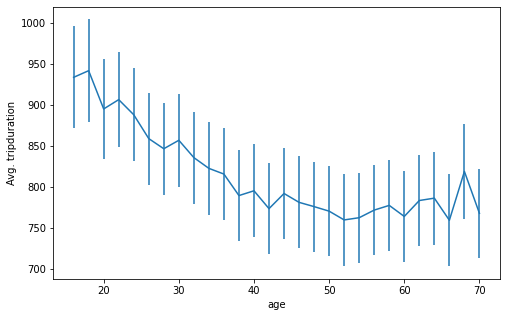

In [28]:
# make a line plot for different age groups
bin_edges = np.arange(15, 70+2, 2)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
age_binned = pd.cut(df['age'], bins=bin_edges, include_lowest=True)

# get the mean and std for the line plot
trip_mean = df['tripduration'].groupby(age_binned).mean()
trip_std = df['tripduration'].groupby(age_binned).std()

# Plot the summarised data on a line plot 
# with error bars representing 0.1 std (variance too large for this data)
plt.figure(figsize=(8, 5))
plt.errorbar(x=bin_centers, y=trip_mean, yerr=0.1 * trip_std)
plt.xlabel('age')
plt.ylabel('Avg. tripduration');

Clearly younger people (below the age of 30) take more time on a bike ride.

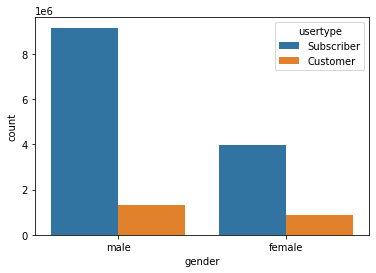

In [29]:
# gender against usertype on an adapted bar chart
sns.countplot(data=df, x='gender', hue='usertype');

The tall bar tells us that there are much more male subscribers than the other gender/subscription types.

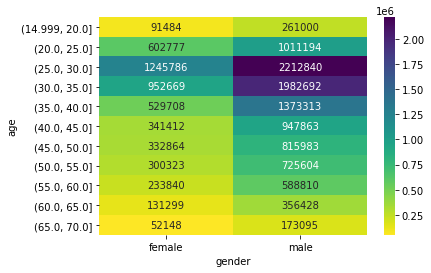

In [30]:
# gender against age on a heatmap
# bin the ages with a 5 years interval
bin_edges = np.arange(15, 70+5, 5)
age_binned = pd.cut(df['age'], bins=bin_edges, include_lowest=True)

# group by gender and age and make the counts
counts = df.groupby(['gender', age_binned]).size()
counts = counts.reset_index(name='counts')

# prepare for the heatmap
heat_plot = counts.pivot_table(index='age', columns='gender', values='counts')
ax = sns.heatmap(heat_plot,
                 annot=True,
                 fmt='.0f',
                 cmap='viridis_r');

Male, aged between 25 and 35 are the population that ride bikes the most in the city. Either because of a larger population base or an age/gender preference, this age group within the males plays a big role in bike hiring.

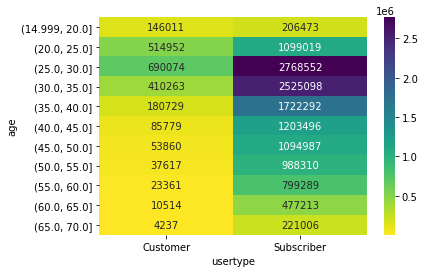

In [31]:
# usertype against age on a heatmap
# use the same age bins as before
# group by usertype and age and make the counts
counts = df.groupby(['usertype', age_binned]).size()
counts = counts.reset_index(name='counts')

# prepare for the heatmap
heat_plot = counts.pivot_table(index='age', columns='usertype', values='counts')
ax = sns.heatmap(heat_plot,
                 annot=True,
                 fmt='.0f',
                 cmap='viridis_r');

As we have seen that most males and females are subscribers and also Male subscribers dominate the number of bike rides from the bar chart above, and we have also seen that males aged between 25 and 35 are the population that ride bikes the most in the city from the previous heatmap plot. It makes sense that a heatmap for age against usertype shows that most bike riders are subscribers, aged between 25 and 35.

We conclude that there is a strong positive correlation between number of bike rides and a male gender, an age group of 25 to 35 and an annual membership.

## Multivariate Exploration

In this section, we will create plots of three or more variables to investigate our data even
further. We will make sure that our investigations are justified, and follow from
our work in the previous sections.

We have seen that shorter distance trips do not necessarily take shorter times to complete, and we think that it's because people may make stops on the way or take detours / longer routes. I wonder if this is linked to a particular type of people (subscriber/customer, age group, gender group)?

In [32]:
# randomly pick 1% of the whole dataset to speed up plotting
df_shorttrips = df.sample(frac=0.01, replace=False, random_state=1)

# filter for only those trips that are between two closeby stations, 
# but not limited to any trip duration
df_shorttrips = df_shorttrips[df_shorttrips['dist stations'] <= 2]

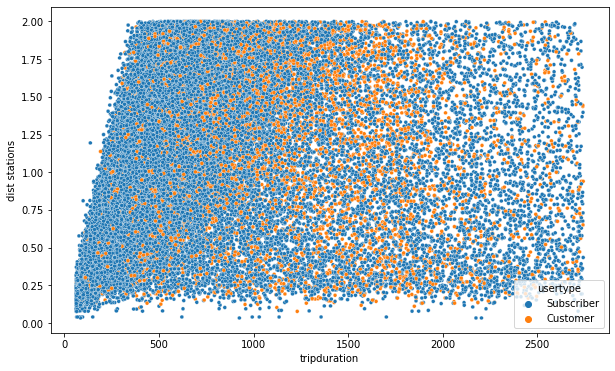

In [33]:
# are subscribers more likely to take a longer time on a trip?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_shorttrips,
                x='tripduration',
                y='dist stations',
                hue='usertype',
                s=15)

There is a slight rightward offset between the amber points (customer) and the blue points (subscriber), indicating a tendency for customers to spend longer times on a same distance trip.

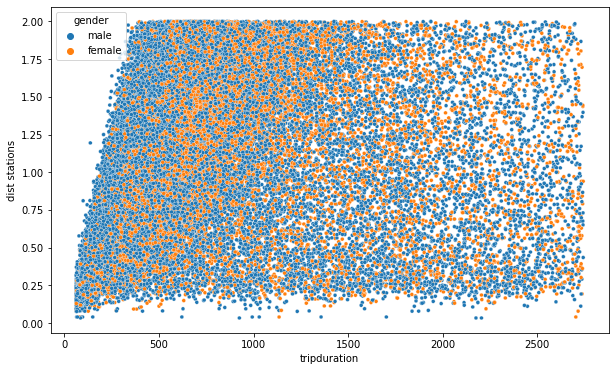

In [34]:
# are males more likely to take a longer time on a trip?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_shorttrips,
                x='tripduration',
                y='dist stations',
                hue='gender',
                s=15)

The initial inclination of the amber points (female) appears to be less steep than the blue points (male). This can be explained by women generally riding at a lower speed than men. The rest of the plot shows no evidence in women taking more time (e.g. wondering about / making stops) than men.

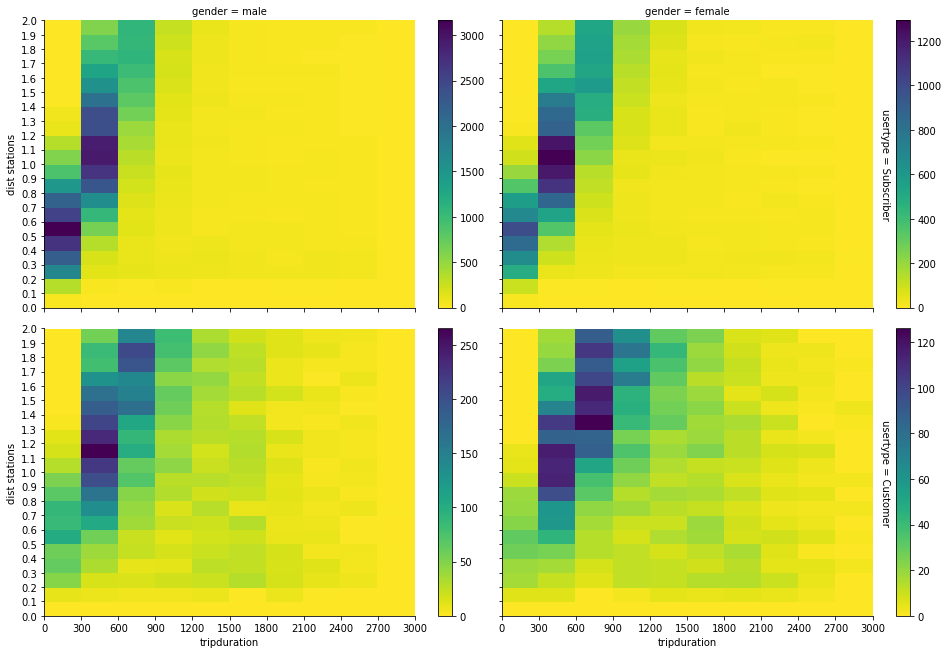

In [170]:
# Summarise the two plots above in a facet plot
g = sns.FacetGrid(data=df_shorttrips,
                  col='gender',
                  row='usertype',
                  margin_titles=True,
                  height=4.5,
                  aspect=1.5)

# map a hist2d plot each with a colorbar onto the facet
bins_x = np.arange(0, 3000 + 300, 300)  # every 5min (300s)
bins_y = np.arange(0, 2 + 0.1, 0.1)  # every 100m

def hist2d(data, color):
    plt.hist2d(data['tripduration'],
               data['dist stations'],
               cmap='viridis_r',
               bins=[bins_x, bins_y])
    plt.colorbar()

g.map_dataframe(hist2d)
g.set_axis_labels("tripduration", "dist stations")
g.set(xticks=bins_x, yticks=bins_y);

The above findings are strengthened here with the heatmap (2D histogram).

More darker colours are on the right of the plots for customers (bottom row) than for subscribers (top row). This illustrates significantly fewer (in proportion) subscribers spend longer times on bike rides than customers. In other words, customer users (who are on a 24-hr or 3-day pass) tend to spend more time on their bike ride. This makes sense because customers would wish to make most use of their limited-time passes.

On the other hand, the darker colours follow a steeper line for male users (left column) than that for female users (right column), but these colours do not comparably (between male and female) occupy more areas to the right of the plots. This means that there is no tendency for women to spend more / less time on a ride than men other than due to speed of ride.

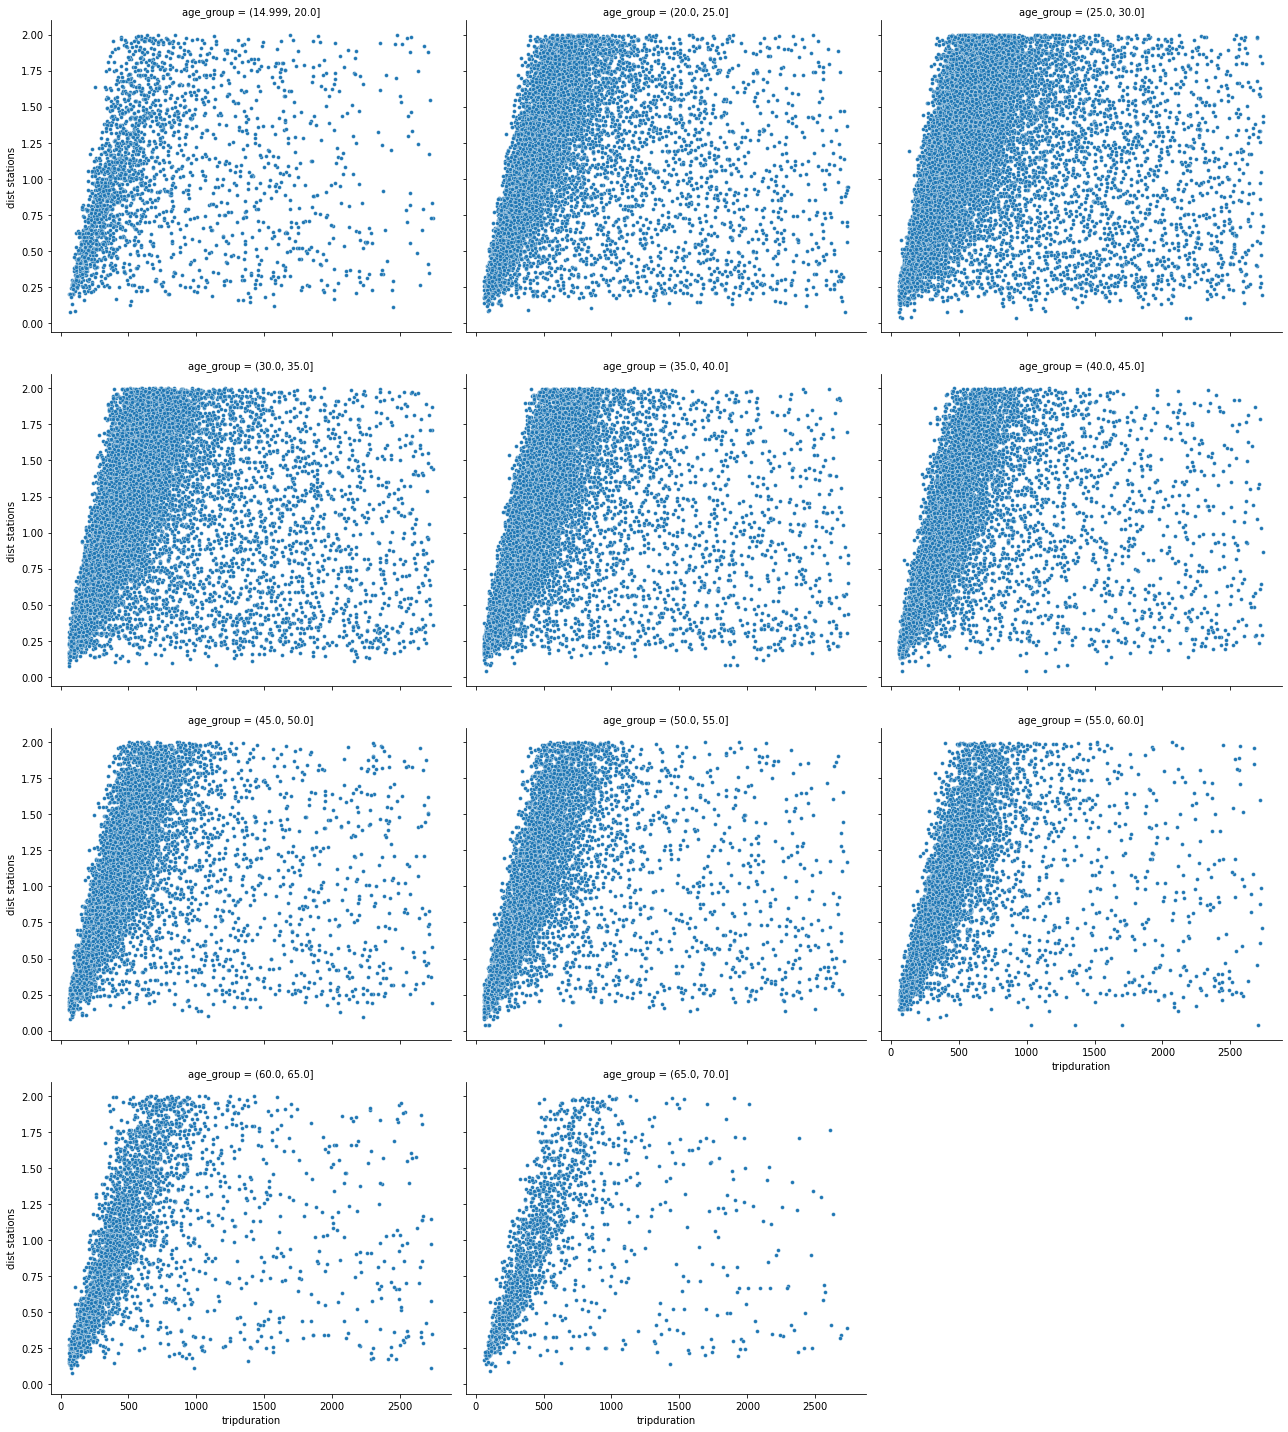

In [44]:
# is a particular age range associated with longer trip duration then?
# due to the volume of different coloured points a scatter plot would have,
# we will facet the plots on age groups
bin_edges = np.arange(15, 70 + 5, 5)
df_shorttrips['age_group'] = pd.cut(df_shorttrips['age'],
                                    bins=bin_edges,
                                    include_lowest=True)

# make a facet plot:
g = sns.FacetGrid(data=df_shorttrips,
                  col='age_group',
                  col_wrap=3,
                  height=5,
                  aspect=1.2)
g.map(sns.scatterplot, 'tripduration', 'dist stations', s=15)

There is no differential pattern associated with age - most people spend time on trips proportional to distance between stations and there is no pattern in the spread of points to the right of each plot. 

The slope of the cluster on each plot indicates the average riding speed for each age group. Then obviously older people have a more gradual slope in the plots due to them riding at lower speeds.